# Step 5: Feature Engineering for NYC 311 Modeling

This notebook demonstrates the complete feature engineering pipeline for three modeling tracks:
1. **Forecast** - Time-series forecasting of ticket arrivals
2. **Triage** - Ticket prioritization at creation time
3. **Duration** - Survival modeling for time-to-close

All features are **leakage-safe** and use **H3-based spatial grouping**.


In [1]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

from src import preprocessing
from src import features
from src import config
from src import forecast

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Usage Instructions

This notebook uses the feature engineering module from `src/features.py`.

To run this notebook:
1. Ensure you have data in `data/landing/311-service-requests/`
2. Run `pip install -r requirements.txt` to install dependencies
3. Execute cells sequentially

For detailed documentation, see `src/FEATURE_ENGINEERING_README.md`


## Load Data

In [2]:
forecast_panel = pd.read_parquet(config.PRESENTATION_DATA_PATH + '/model_fitting_data.parquet')
df_streamlit = pd.read_parquet(config.PRESENTATION_DATA_PATH + '/streamlit_data.parquet')


## Fit Modesl

In [3]:
numerical_columns = [
            'lag1', 'lag4', 'roll4', 'roll12',
            'momentum', 'weeks_since_last',
            'tavg', 'prcp', 'heating_degree', 'cooling_degree',
            'rain_3d', 'rain_7d', 'log_pop', 'nbr_roll4', 'nbr_roll12'
        ]

categorical_columns = ['week_of_year', 'month',  'heat_flag', 'freeze_flag', 'hex6', 'complaint_family']
horizons = [1]

poisson_params = {
            'objective': 'poisson',
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }


tweedie_params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,   # try 1.1–1.6 during tuning
    "learning_rate": 0.05,
    "n_estimators": 1200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

### Hyper Parameter Tuning

In [7]:
df_input = forecast_panel.copy()
horizon = 1
input_columns = df_input.columns

In [ ]:
dict_results = forecast.tune(
    df_input,
    horizon,
    input_columns,
    numerical_columns,
    categorical_columns,
)

Tuning forecast model with 30 trials...
X shape pre-filtering: (442520, 27)
X shape post-filtering: (425330, 27)


### Fit Mean Models

In [4]:
bundle_mean = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (442520, 28)
X shape post-filtering: (425330, 28)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (412733, 28)
X test shape: (12597, 28)
CV (neg_mean_absolute_error) scores: [-0.60189893 -0.61819663 -0.61098389 -0.6418502  -0.67507303 -0.71173597
 -0.70446612 -0.68596454 -0.71923818 -0.51472184 -0.58659253 -0.62017237
 -0.60072698 -0.6566914 ]
CV mean: -0.6391651852692085
train metrics
  h=1: RMSE=1.010, MAE=0.638, Poisson Dev=1.031
test metrics
  h=1: RMSE=1.115, MAE=0.622, Poisson Dev=1.031



### Fit 90th Percentile Models

In [5]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.9,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_90 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (442520, 28)
X shape post-filtering: (425330, 28)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (412733, 28)
X test shape: (12597, 28)
CV (neg_mean_absolute_error) scores: [-1.09818262 -1.1713862  -1.20067454 -1.22593339 -1.27930039 -1.33031424
 -1.35274851 -1.3503623  -1.38681129 -1.08194388 -1.1013049  -1.21260466
 -1.18789751 -1.21008539]
CV mean: -1.2278249865346482
train metrics
  h=1: RMSE=1.682, MAE=1.285, Poisson Dev=2.033
test metrics
  h=1: RMSE=1.764, MAE=1.235, Poisson Dev=1.974



### Fit 50th Percentile Models

In [6]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_50 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (442520, 28)
X shape post-filtering: (425330, 28)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (412733, 28)
X test shape: (12597, 28)
CV (neg_mean_absolute_error) scores: [-0.51107493 -0.53478157 -0.52122273 -0.5582883  -0.59737175 -0.64469301
 -0.63242397 -0.60601262 -0.64847553 -0.39284891 -0.49849438 -0.5188047
 -0.51057688 -0.58174253]
CV mean: -0.5540579865916319
train metrics
  h=1: RMSE=1.133, MAE=0.561, Poisson Dev=6.992
test metrics
  h=1: RMSE=1.147, MAE=0.525, Poisson Dev=6.832



### Fit 10th Percentile Models

In [7]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.1,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_10 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (442520, 28)
X shape post-filtering: (425330, 28)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (412733, 28)
X test shape: (12597, 28)
CV (neg_mean_absolute_error) scores: [-0.58640408 -0.64472456 -0.60392465 -0.6762713  -0.74598562 -0.78806744
 -0.77457979 -0.73074198 -0.81254127 -0.42260711 -0.59070564 -0.61990252
 -0.6265581  -0.72198705]
CV mean: -0.667500078997951
train metrics
  h=1: RMSE=1.475, MAE=0.683, Poisson Dev=25.129
test metrics
  h=1: RMSE=1.600, MAE=0.648, Poisson Dev=21.725



### Save All Bundles

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
forecast.save_bundle(bundle_mean,  timestamp, 'lgb_mean.pkl')
forecast.save_bundle(bundle_90,  timestamp, 'lgb_90.pkl')
forecast.save_bundle(bundle_50,  timestamp, 'lgb_50.pkl')
forecast.save_bundle(bundle_10,  timestamp, 'lgb_10.pkl')

Model bundle saved to: c:\Users\gorav\GitHub\nyc-311-service-requests\models\20251005_170606\just_model\lgb_mean.pkl
Model bundle saved to: c:\Users\gorav\GitHub\nyc-311-service-requests\models\20251005_170606\just_model\lgb_90.pkl
Model bundle saved to: c:\Users\gorav\GitHub\nyc-311-service-requests\models\20251005_170606\just_model\lgb_50.pkl
Model bundle saved to: c:\Users\gorav\GitHub\nyc-311-service-requests\models\20251005_170606\just_model\lgb_10.pkl


## Evaluate Models

### Evaluate Mean Models

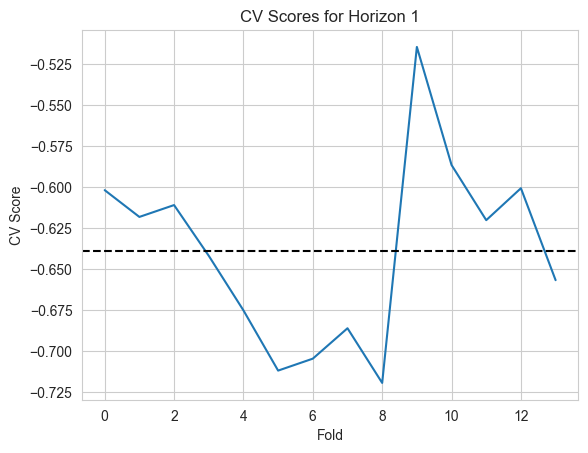

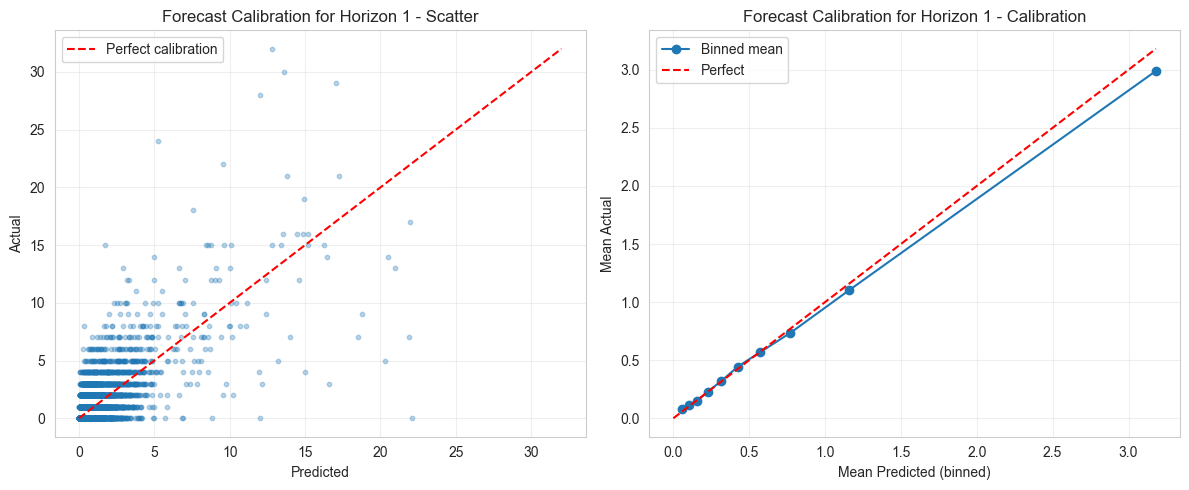

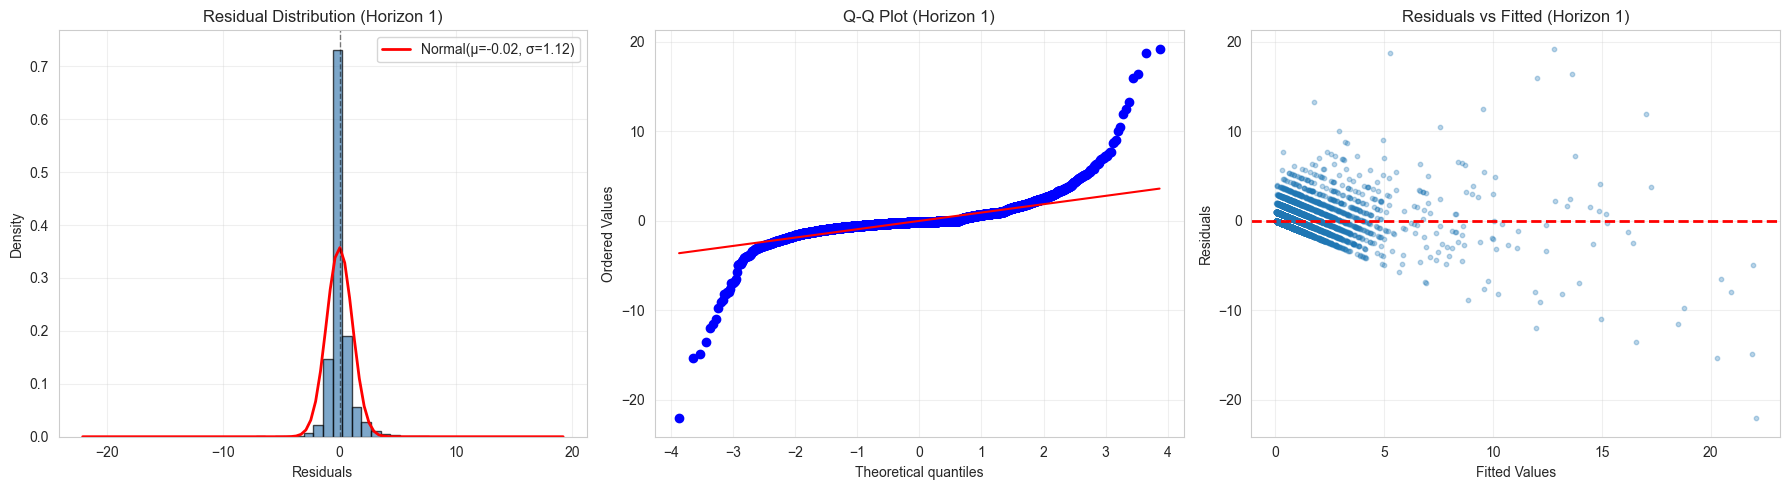


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -0.0241
  Std Dev: 1.1151
  Median: -0.1508
  Skewness: 1.1004
  Kurtosis: 54.5363

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.7366
  P-value: 6.6337e-67
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 859.4885
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.0101139264976293, 'mae': 0.6376189923291886, 'poisson_deviance': 1.031246972700663, 'n_samples': 412733}, 'test': {'horizon': 1, 'rmse': 1.1152810464364165, 'mae': 0.622167570828557, 'poisson_deviance': 1.0314914473896057, 'n_samples': 12597}}



In [9]:
reload(forecast)
forecast.evaluate_models(bundle_mean)

### Evaluate 90th Percentile Models

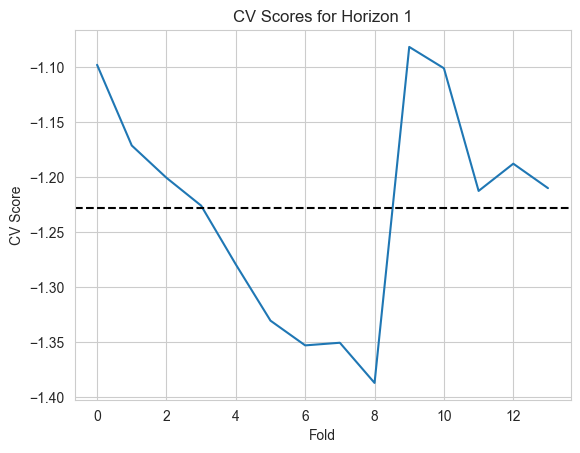

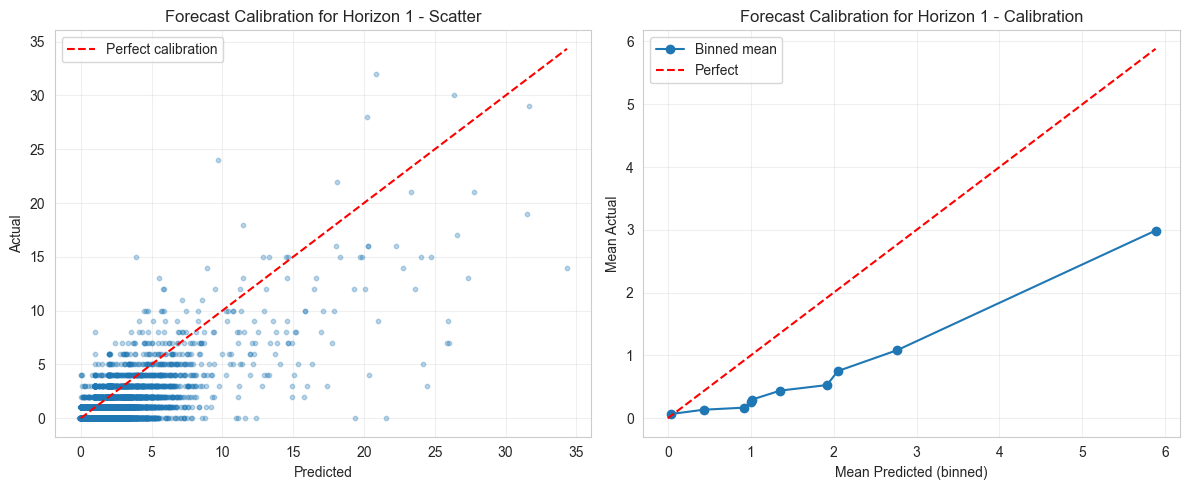

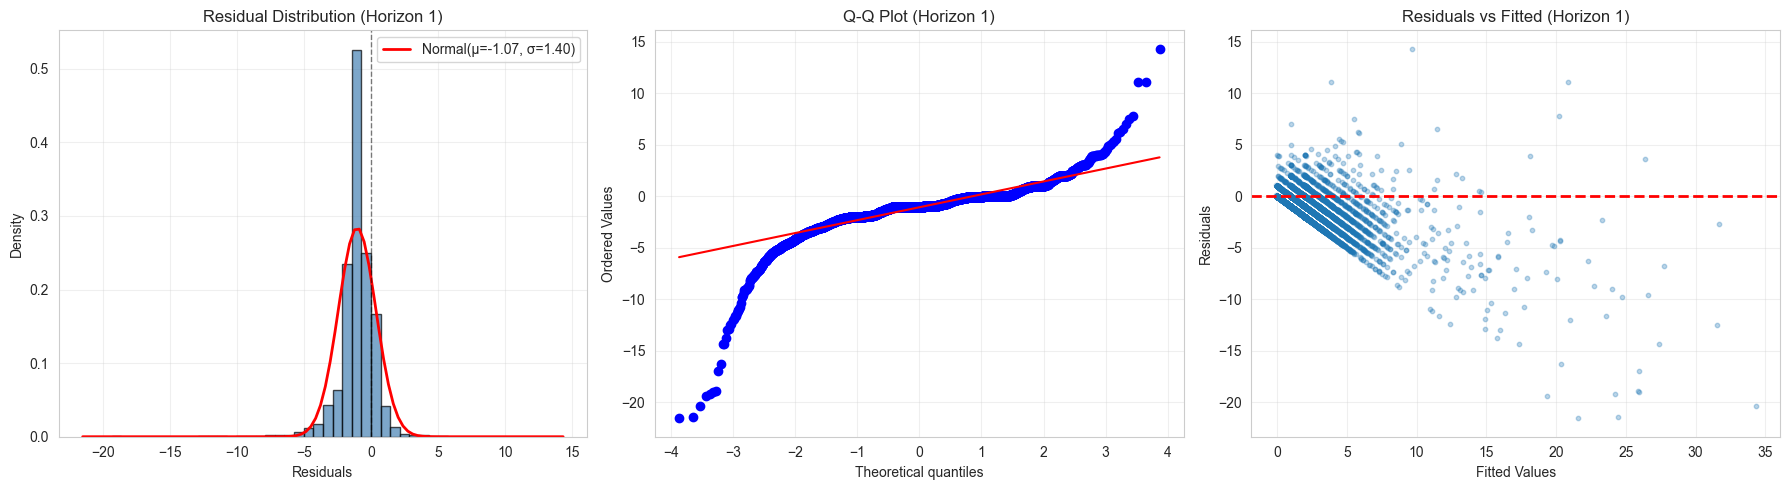


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -1.0666
  Std Dev: 1.4047
  Median: -0.9974
  Skewness: -2.5863
  Kurtosis: 31.0697

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8034
  P-value: 2.8891e-61
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 462.4413
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.6819248565797669, 'mae': 1.2849980756723283, 'poisson_deviance': 2.03255628951899, 'n_samples': 412733}, 'test': {'horizon': 1, 'rmse': 1.7636928270286534, 'mae': 1.2352015865632215, 'poisson_deviance': 1.9743698421664946, 'n_samples': 12597}}



In [10]:
reload(forecast)
forecast.evaluate_models(bundle_90)

### Evaluate 50th Percentile Models

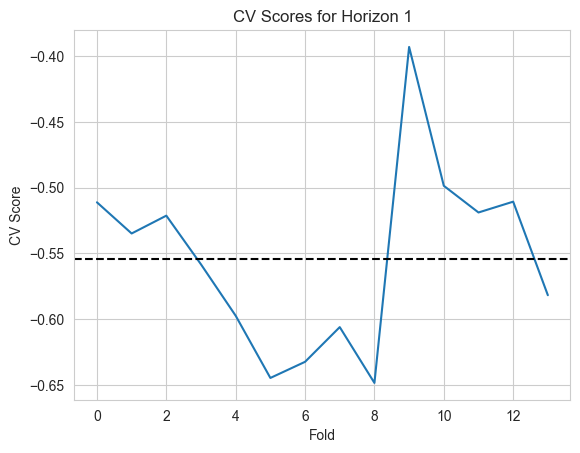

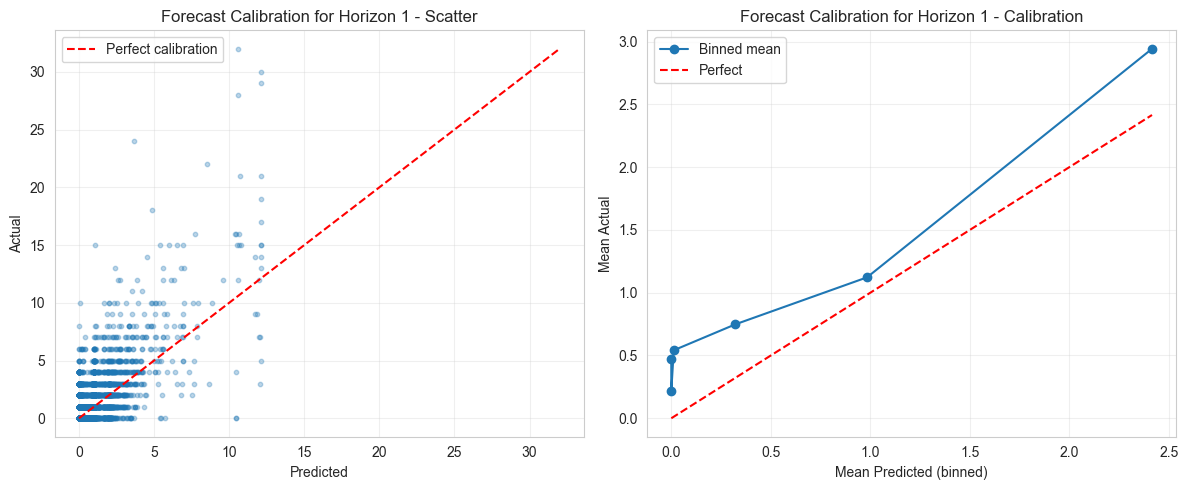

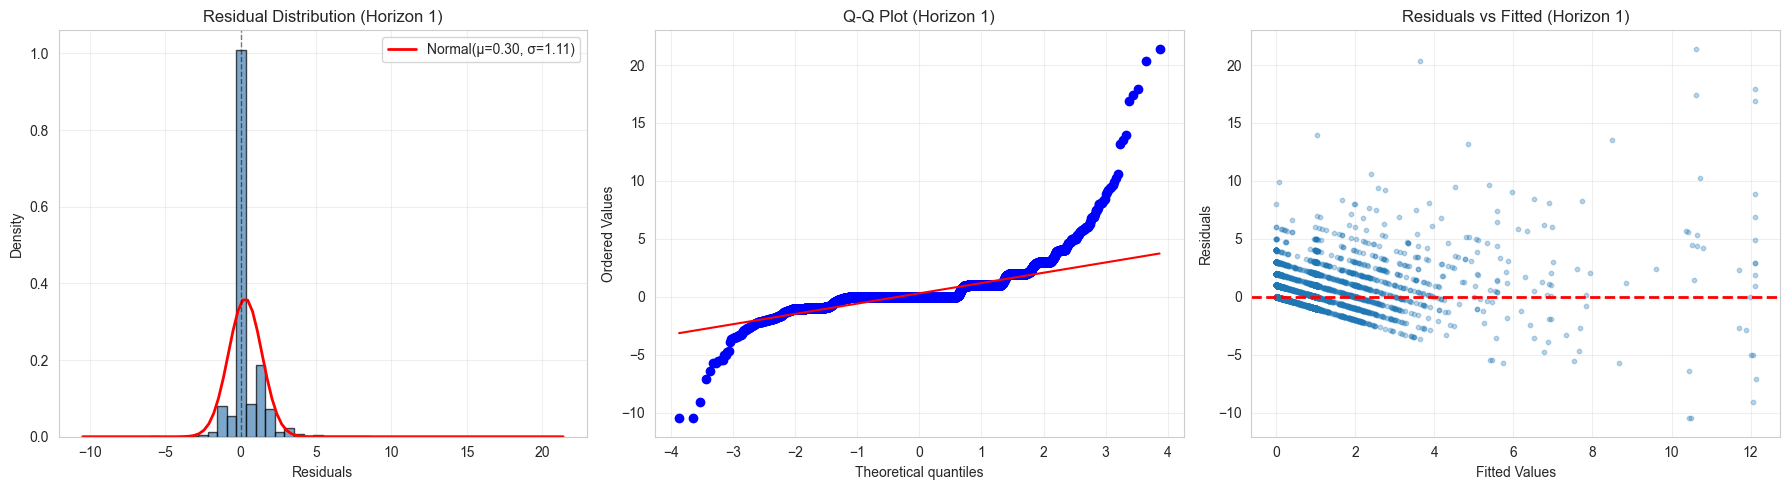


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.2989
  Std Dev: 1.1074
  Median: 0.0000
  Skewness: 3.8270
  Kurtosis: 48.3037

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6377
  P-value: 2.4532e-73
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1426.0435
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.1329803242333623, 'mae': 0.5608002098837983, 'poisson_deviance': 6.99170331215775, 'n_samples': 412733}, 'test': {'horizon': 1, 'rmse': 1.1470136064455283, 'mae': 0.525228119659673, 'poisson_deviance': 6.832439526143078, 'n_samples': 12597}}



In [11]:
reload(forecast)
forecast.evaluate_models(bundle_50)

### Evaluate 10th Percentile Models

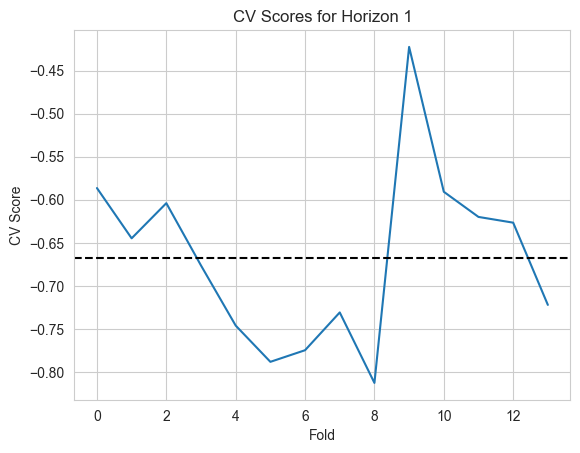

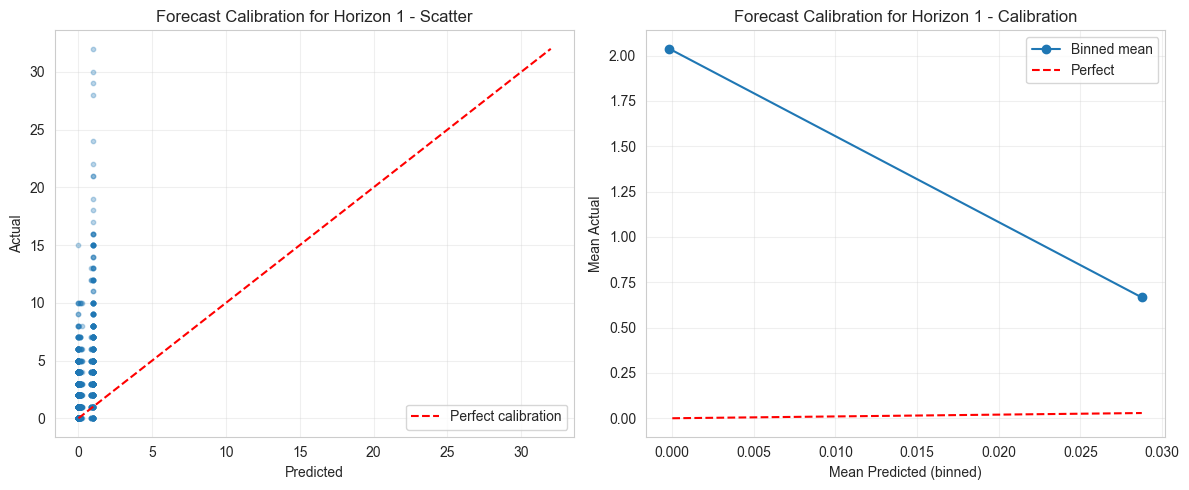

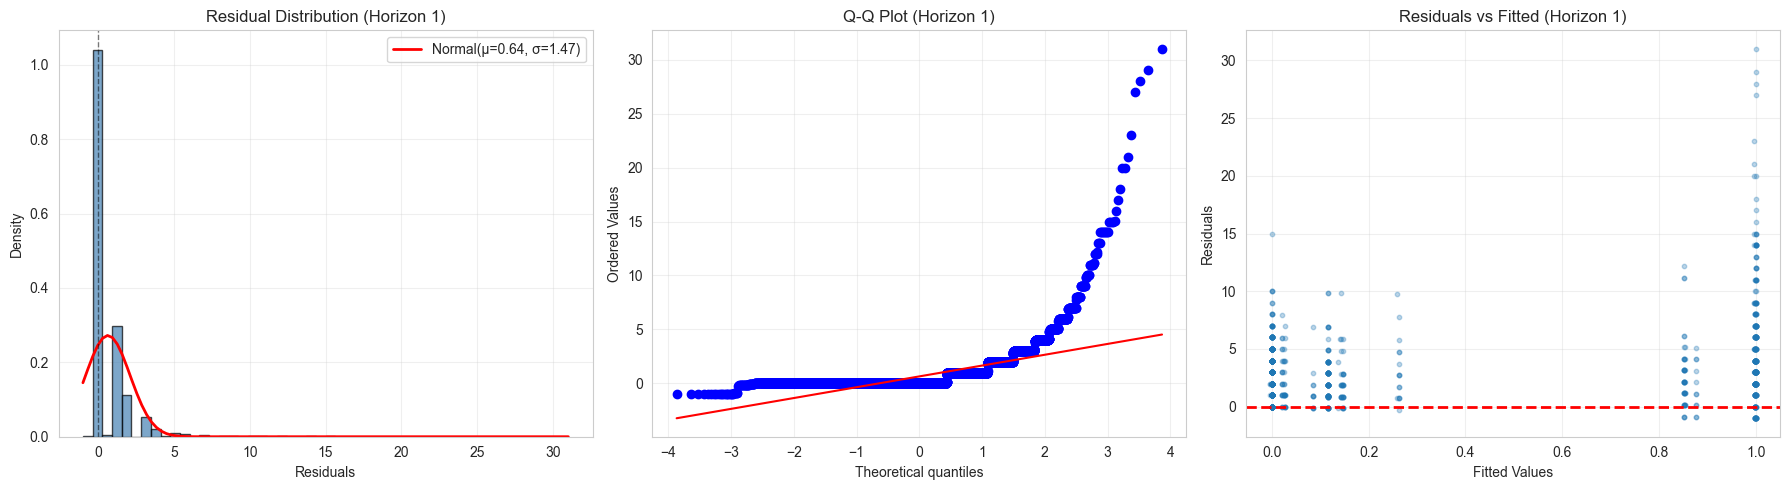


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.6436
  Std Dev: 1.4651
  Median: 0.0000
  Skewness: 6.3722
  Kurtosis: 75.5296

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.4450
  P-value: 2.0191e-82
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1970.5040
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.4752034657140827, 'mae': 0.6825583372468909, 'poisson_deviance': 25.129036602875694, 'n_samples': 412733}, 'test': {'horizon': 1, 'rmse': 1.6001535044693949, 'mae': 0.6477468556691083, 'poisson_deviance': 21.725189651660965, 'n_samples': 12597}}



In [12]:
reload(forecast)
forecast.evaluate_models(bundle_10)

In [14]:

weeks_list = df_streamlit['week'].unique()

In [15]:
weeks_list

<DatetimeArray>
['2025-02-04 00:00:00', '2025-05-06 00:00:00', '2025-07-15 00:00:00',
 '2025-07-01 00:00:00', '2025-06-10 00:00:00', '2025-01-07 00:00:00',
 '2025-02-25 00:00:00', '2025-06-03 00:00:00', '2025-04-15 00:00:00',
 '2025-06-24 00:00:00', '2025-07-08 00:00:00', '2025-07-22 00:00:00',
 '2025-07-29 00:00:00', '2025-01-14 00:00:00', '2025-02-18 00:00:00',
 '2025-04-22 00:00:00', '2025-04-01 00:00:00', '2025-03-11 00:00:00',
 '2025-06-17 00:00:00', '2025-02-11 00:00:00', '2025-04-29 00:00:00',
 '2025-05-13 00:00:00', '2025-01-21 00:00:00', '2025-04-08 00:00:00',
 '2025-03-18 00:00:00', '2025-05-27 00:00:00', '2025-01-28 00:00:00',
 '2025-03-04 00:00:00', '2025-05-20 00:00:00', '2025-03-25 00:00:00']
Length: 30, dtype: datetime64[ns]

### Misc

In [ ]:
last_rows = panel.groupby(['hex', 'complaint_family']).last().reset_index()

# Predict 7 days ahead
predictions = forecast.predict_forecast(bundles, last_rows, horizon=7)

In [ ]:
last_rows

In [ ]:
predictions

In [ ]:
# triage_features, tfidf_matrix, vectorizer = features.build_triage_features(df)
# duration_labels = features.build_duration_survival_labels(df)
# duration_features = features.build_duration_features(df, triage_features)
